In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from torch.utils.data import Dataset
import scipy.io
import torch
import pytorch_lightning as pl
!pwd

sys.path.append('../')
from module.Pingfan_ver2_datamodule import MRIDataModule
from script.trainer import our_GRU, model_load_matcher

import pwd

from jinja2 import ModuleLoader
import pytorch_lightning as pl
import torch
import torchvision
from torch.utils.data import random_split, DataLoader, Dataset
import sys
import mat73
import h5py
from torch.nn import functional as F

from Bloch_decoder.utils.generate_RF_TR import generate_RF_TR
from pytorch_lightning.trainer.supporters import CombinedLoader
import pytorch_lightning as pl


import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.jit as jit
import warnings
from collections import namedtuple
from typing import List, Tuple
from torch import Tensor
import numbers
import scipy.io
import pytorch_lightning as pl

import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from functools import total_ordering

/mnt/ssd/jj/Research/cauMedical/lightning_bolts/script


In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

# The Bloch equation

In [3]:
class Top_MRI_simulator:
    def __init__(self):
        pass

    def build_dictionary_fisp(
        self,
        L=1000,
        RFpulses=10 * math.pi / 180 * torch.randn(1000),
        TR=torch.randn(1000) * 4 + 10,
        TE=2,
        T1_values=torch.hstack([torch.arange(100, 2000, 20), torch.arange(2300, 5000, 300)]),
        T2_values=torch.hstack([torch.arange(20, 100, 5), torch.arange(110, 200, 10), torch.arange(300, 1900, 200)]),
    ):

        """
        This function simulates a dictionary of temporal MRI signals for specified RF pulses, TR times, TE times, pairs of T1 and T2 values via calling epg_fisp_mrf.
        Note, each pair of T1, T2 value gives a temporal signal. T1, T2 values are used to constructed into pairs in a combinatorial way,
        e.g. T1 = [8,6];  T2 = [2, 3] give 4 pairs {(T1,T2)} = {(8,2),(8,3),(6,2),(6,3)}, thus output 4 signals.
        # % T1_values: T1 parameters, 1D array e.g. T1_values = [1:10:5000];
        # % T2_values: T2 parameters, 1D array e.g. T2_values = [1:10:2000];
        # % L:  integer, the whole MRI sequence length;
        # % TR: must be float, 1D array of repetition time;
        # % TE: must be float, echo time;
        e.g.
        D, LUT = build_dictionary_fisp(L=200,RFpulses=10*math.pi/180*np.random.rand(200),
                              TR=np.random.rand(200)*4+10,TE=2,
                              T1_values=np.arange(100,2000,200),
                              T2_values=np.arange(20,100,50))
        """

        num_size_ = min(len(T1_values), len(RFpulses))
        FISP_dictionary = torch.zeros((num_size_, L), dtype=torch.complex64).cuda()
        LUT = torch.zeros((num_size_, 2)).cuda()

        # Return Scale of values
        RFpulses = RFpulses * torch.pi / 180  # Turning back from degree to orinigal
        T1_values = torch.pow(10, T1_values)  # / 1000  # Turning back from log 10 to original
        T2_values = torch.pow(10, T2_values)  # / 1000  # TE, TR divided by 1000 already done in datamodule
        TR = TR * 1000
        TE = TE * 1000
        
        print(TE.mean())

        # Original scale
        T1_values = T1_values / 1000.0
        T2_values = T2_values / 1000.0
        TR = TR / 1000.0
        TE = TE / 1000.0
        RFpulses = RFpulses * 1j
        
        print(TE.mean())

        RR = self.gen_RR(RFpulses)
        self.middle = Middle_MRI_simulator(RFpulses=RFpulses, TR_times=TR, TE_times=TE, RR=RR)
        LUT = torch.stack([T1_values, T2_values], 1)
        FISP_dictionary = self.middle.forward(T1_values, T2_values)
        FISP_dictionary = self.cuda_norm(FISP_dictionary, p=2, dim=1)

        # Exception : If T1<T2 or T1<0 or T2<0
        # ind_wrong = torch.where(T1_values < T2_values)[0]
        # FISP_dictionary[ind_wrong] = (
        #     torch.ones((FISP_dictionary[0].shape)).type(torch.complex64).cuda()
        #     * 1e3
        #     * ((T2_values - T1_values).mean())
        # )

        # ind_wrong = torch.where(T1_values < 0)[0]
        # FISP_dictionary[ind_wrong] = (
        #     torch.ones((FISP_dictionary[0].shape)).type(torch.complex64).cuda() * 1e3 * ((-T1_values).mean())
        # )

        # ind_wrong = torch.where(T2_values < 0)[0]
        # FISP_dictionary[ind_wrong] = (
        #     torch.ones((FISP_dictionary[0].shape)).type(torch.complex64).cuda() * 1e3 * ((-T2_values).mean())
        # )

        # ####
        # print(len(T1_values), (T1_values < T2_values).sum(), (T1_values < 0).sum(), (T2_values < 0).sum())
        # FISP_dictionary = torch.ones((num_size_, L), dtype=torch.complex64).cuda() * T1_values[0] * T2_values[0]
        # #####

        #######

        return FISP_dictionary, LUT

    def cuda_norm(self, input, p, dim, eps=1e-12):
        denom = torch.linalg.norm(input, dim=1, ord=2, keepdim=True)
        # denom = input.norm(p, dim, keepdim=True)
        eps_ = torch.ones_like(input).type(torch.float) * eps
        denom = torch.where(abs(denom) < abs(eps_), eps_, denom)
        # denom = torch.clamp(denom, min=eps)
        denom = denom.expand_as(input)
        return input / denom

    def gen_RR(self, RFpulses):
        alpha_s = torch.abs(RFpulses[0, :])
        phi_s = torch.angle(RFpulses[0, :])
        save_RR = []
        for i in range(len(alpha_s)):
            alpha = alpha_s[i]
            phi = phi_s[i]
            RR = [
                [
                    (torch.cos(alpha / 2.0)) ** 2.0,
                    torch.exp(2.0 * 1j * phi) * (torch.sin(alpha / 2.0)) ** 2.0,
                    -1j * torch.exp(1j * phi) * torch.sin(alpha),
                ],
                [
                    torch.exp(-2.0 * 1j * phi) * (torch.sin(alpha / 2.0)) ** 2.0,
                    (torch.cos(alpha / 2.0)) ** 2.0,
                    1j * torch.exp(-1j * phi) * torch.sin(alpha),
                ],
                [
                    -1j / 2.0 * torch.exp(-1j * phi) * torch.sin(alpha),
                    1j / 2.0 * torch.exp(1j * phi) * torch.sin(alpha),
                    torch.cos(alpha),
                ],
            ]
            save_RR.append(RR)

        RR = torch.tensor(save_RR).type(torch.complex64).cuda()  # torch.tensor(RR).type(torch.complex64) #.cuda() #RR
        return RR


class Middle_MRI_simulator(jit.ScriptModule):
    def __init__(self, RFpulses, TR_times, TE_times, RR):
        super().__init__()
        self.Nstates = 20  #% Number of states to simulate
        self.RFpulses = RFpulses
        self.TR_times = TR_times
        self.TE_times = TE_times
        self.RR = RR

        self.batch = TR_times.shape[0]
        self.length = TR_times.shape[1]

        self.P = torch.zeros((self.batch, 3, self.Nstates)).cuda()  #% State matrix
        self.P[:, 2, 0] = -1  #% Equilibrium magnetization.
        self.Dict = torch.zeros(
            self.batch, self.length, dtype=torch.complex64
        ).cuda()  #% Vector holding the recieved signals.

        self.flipang = torch.abs(self.RFpulses[0, :])
        self.flipphase = torch.angle(self.RFpulses[0, :])

    def epg_rf(self, FpFmZ, RR):
        ######
        return_rotation = False
        frames = 1
        ploton = True
        #####
        """
        Simulate the effect of the RF pulse sequence. 

        """

        FpFmZ = FpFmZ.type(torch.complex64).requires_grad_(True).cuda()

        ########
        #         alpha = alpha.cpu().numpy()
        #         phi = phi.cpu().numpy()
        #         RR = torch.tensor([[(torch.cos(alpha/2.))**2., torch.exp(2.*1j*phi)*(torch.sin(alpha/2.))**2., -1j*torch.exp(1j*phi)*torch.sin(alpha)],
        #           [torch.exp(-2.*1j*phi)*(torch.sin(alpha/2.))**2., (torch.cos(alpha/2.))**2., 1j*torch.exp(-1j*phi)*torch.sin(alpha)],
        #           [-1j/2.*torch.exp(-1j*phi)*torch.sin(alpha), 1j/2.*torch.exp(1j*phi)*torch.sin(alpha),      torch.cos(alpha)]])

        RR = RR.type(torch.complex64).cuda()  # torch.tensor(RR).type(torch.complex64) #.cuda() #RR
        ########
        return torch.matmul(RR, FpFmZ)

    def epg_relax(self, FpFmZ, T1, T2, T):

        """
        Simulate the effect of T1, T2 relaxation.

        """
        E2 = torch.exp(-T / 1.0 / T2)
        E1 = torch.exp(-T / 1.0 / T1)

        ###########
        st = torch.stack((E2, E2, E1), 1)
        EE = torch.diag_embed(st)
        ###########

        EE = EE.type(torch.complex64).cuda()
        RR = 1 - E1

        FpFmZ = torch.matmul(EE, FpFmZ)
        ###########
        FpFmZ[:, 2, 0] = FpFmZ[:, 2, 0] + RR
        ###########
        return FpFmZ

    def epg_grad(self, FpFmZ):
        """
        Simulate the effect of positive gradients.
        """

        FpFmZ[:, 0, 1:] = FpFmZ[:, 0, :-1].clone()
        FpFmZ[:, 1, :-1] = FpFmZ[:, 1, 1:].clone()
        FpFmZ[:, 1, -1] = 0
        FpFmZ[:, 0, 0] = torch.conj(FpFmZ[:, 1, 0].clone())

        return FpFmZ

    def epg_mgrad(self, FpFmZ):
        """
        Simulate the effect of the negative gradients.
        """
        FpFmZ[:, 1, 1:] = FpFmZ[:, 1, :-1].clone()
        FpFmZ[:, 0, :-1] = FpFmZ[:, 0, 1:].clone()
        FpFmZ[:, 0, -1] = 0
        FpFmZ[:, 1, 0] = torch.conj(FpFmZ[:, 0, 0].clone())
        return FpFmZ

    # add epg_grelax by spf
    def epg_grelax(self, FpFmZ, T1, T2, T):
        """
        %	Propagate EPG states through a period of relaxation, and
        %	diffusion over an interval T, with or without a gradient.
        %	Leave last 3 blank to exclude diffusion effects.
        %
        %	INPUT:
        %		FpFmZ = 3xN vector of F+, F- and Z states.
        %		T1,T2 = Relaxation times (s)
        %		T = Time interval (s)
        %	    (Optional inputs follow)
        %		kg = k-space traversal due to gradient (rad/m) for diffusion
        %		D = Diffusion coefficient (m^2/s)
        %		Gon = 0 if no gradient on, 1 if gradient on
        %			(gradient will advance states at the end.)
        %		noadd=1 to not add higher-order states - see epg_grad.m
        %
        %	OUTPUT:
        %		FpFmZ = updated F+, F- and Z states.
        %		EE = decay matrix, 3x3 = diag([E2 E2 E1]);
        %		BV = b-value matrix, 3xN (see FpFmZ) of attenuations.
        """
        ###########
        BV = None
        EE = None
        kg = 1
        D = 0
        Gon = 1
        noadd = 1
        ###########

        """
        kg = 0; D = 0; #Default ignore diffusion
        noadd=0 # Default is to add states.
        Gon = 1 # Default is Gon.
        """

        #     E2 = torch.exp(-T/1./T2)
        #     E1 = torch.exp(-T/1./T1)

        #     ###########
        #     st = torch.stack((E2,E2,E1),1)
        #     EE = torch.diag_embed(st)
        #     ###########
        #     EE = EE.type(torch.complex64).cuda()
        #     RR = 1-E1

        #     FpFmZ = torch.matmul(EE,FpFmZ)
        #     ##########
        #     FpFmZ[:, 2, 0] = FpFmZ[:, 2, 0] + RR
        #     ########

        if int(Gon) == 1:
            if int(kg) >= 0:
                FpFmZ = self.epg_grad(FpFmZ)
                #% Advance states.

            else:
                FpFmZ = self.epg_mgrad(FpFmZ)
                #% Advance states by negative gradient.

        return FpFmZ, EE, BV

    @jit.script_method
    def forward(self, T1, T2):

        # %simulation of FISP using EPG. All times are in seconds and angles are in Radians
        P = self.P
        for k in range(int(self.length)):
            TR = self.TR_times[:, k]
            TE = self.TE_times[:, k]
            flipang = self.flipang[k]
            flipphase = self.flipphase[k]

            #% RF pulse
            P = self.epg_rf(P, self.RR[k])

            #% FID for time TE and then sample signal
            P = self.epg_relax(P, T1, T2, TE)  #% Relaxation. -spf
            self.Dict[:, k] = P[:, 0, 0]  #% Signal is F0 state.

            #% -- Simulate relaxation and spoiler gradient
            P, EE, BV = self.epg_grelax(P, T1, T2, TR - TE)  #% spoiler gradient, relaxation. -spf

        return self.Dict

# Data module

In [4]:


class MRIDataModule(pl.LightningDataModule):
    def __init__(
        self,
        batch_size: int = 1,
        num_workers=0,
        train_data_type="seq",
        test_data_type="real",
        subsamp=1,
        seq_jump=5,
        is_input_RF=0,
        need_T1T2_logscale=True,
        need_TETR_second=True,
        need_RF_degree=True,
    ):  # img_cnn, img_seq, seq
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_data_type = train_data_type
        self.testdata_type = test_data_type
        self.subsamp = subsamp
        self.seq_jump = seq_jump
        self.need_T1T2_logscale = need_T1T2_logscale
        self.need_TETR_second = need_TETR_second
        self.need_RF_degree = need_RF_degree
        self.datamodule = PingSeqDataset

        self.n_img_tr = 80 * 128 * 128
        self.n_img_te = 22 * 128 * 128

    def prepare_data(self):
        return

    def setup(self, stage=None):
        # Trainset
        if "seqTr" in self.train_data_type:
            self.trainset = self.datamodule(
                mode="train",
                is_split_range_T1T2=True,
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
        elif "seqAll" in self.train_data_type:
            self.trainset = self.datamodule(
                mode="none",
                is_split_range_T1T2=False,
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
        elif "phantomTr" in self.train_data_type:
            self.trainset = PingImgDataset_Phantom(mode="train")
        elif "phantomAll" in self.train_data_type:
            self.trainset = PingImgDataset_Phantom(mode="none")
        else:
            raise AssertionError("Check traindata_type")

        # Testset
        self.test_seqTe = self.datamodule(
            mode="test",
            is_split_range_T1T2=True,
            need_T1T2_logscale=self.need_T1T2_logscale,
            need_TETR_second=self.need_TETR_second,
            need_RF_degree=self.need_RF_degree,
        )
        self.test_phantomTe = PingImgDataset_Phantom(mode="test")
        self.test_phantomAll = PingImgDataset_Phantom(mode="none")
        self.test_real = PingImgDataset_real(
            need_T1T2_logscale=self.need_T1T2_logscale,
            need_TETR_second=self.need_TETR_second,
            need_RF_degree=self.need_RF_degree,
        )
    

    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):

        # Validation daata loader for all data types
        seqTe = DataLoader(self.test_seqTe, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        phantomTe = DataLoader(
            self.test_phantomTe, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers
        )
        phantomAll = DataLoader(
            self.test_phantomAll, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers
        )
        real = DataLoader(self.test_real, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

        loaders = {
            "seqTe": seqTe,
            "phantomTe": phantomTe,
            "real": real,
            "phantomAll": phantomAll,
        }  # "phantomTe": phantomTe, "phantomAll": phantomAll, "real": real}
        combined_loaders = CombinedLoader(loaders, mode="max_size_cycle")

        return combined_loaders

    def test_dataloader(self):
        return self.val_dataloader()

    def predict_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


class PingSeqDataset(Dataset):
    # Input : T1T2, RF, TE, TR
    def __init__(
        self,
        mode="train",
        is_split_range_T1T2=True,
        need_T1T2_logscale=False,
        need_TETR_second=False,
        need_RF_degree=False,
    ):
        """
        Approx RNN input : (need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True)
        Our Bloch decoder input : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
        This data : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
        """

        L = 1000
        subsamp = 1
        len_seq = L // subsamp
        T1_condition_threshold = 2500
        T2_condition_threshold = 1000
        MRFData = scipy.io.loadmat(
            "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/New_D_LUT_L1000_TE10_Start5_Val.mat"
        )
#         MRFData_Val = scipy.io.loadmat(
#             "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/D_LUT_L1000_TE10_Start5_Val.mat"
#         )  #
#         self.is_split_range_T1T2 = is_split_range_T1T2 if "none" not in mode else False

#         self.labels = np.concatenate((MRFData["LUT"], MRFData_Val["LUT"]), 0)
#         self.labels = torch.from_numpy(self.labels)

#         self.D = np.concatenate((np.real(MRFData["D"]), np.real(MRFData_Val["D"])), 0)
#         self.D = torch.from_numpy(self.D[:, 0:L:subsamp])
#         self.D = torch.nn.functional.normalize(self.D, p=2.0, dim=1)
        
        
        self.is_split_range_T1T2 = is_split_range_T1T2 if "none" not in mode else False

        self.labels = MRFData["LUT"]  # np.concatenate((MRFData["LUT"], MRFData_Val["LUT"]), 0)
        self.D = MRFData["D"]  # np.concatenate((MRFData["D"], MRFData_Val["D"]), 0)

        self.labels = torch.from_numpy(self.labels)
        self.D = torch.from_numpy(self.D[:, 0:L:subsamp])
        
        
         # RF, TR, TE
        RFpulses, TR = generate_RF_TR(L)  #%Load slowly changing RF and TR values
        RFpulses = RFpulses[0:L:subsamp]  #% undersampling in time dimension.

        self.TR = TR[0:L:subsamp].repeat(len(self.labels), 1).unsqueeze(1)
        self.TE = torch.ones(len(self.labels), 1, len_seq) * 10
        self.RFpulses = RFpulses.repeat(len(self.labels), 1).unsqueeze(1)

        if self.is_split_range_T1T2:
            # Split train and test set : T1 0~2500, 2500~5000
            T1 = self.labels[:, 0]
            T2 = self.labels[:, 1]
            condition = (
                (T1 < T1_condition_threshold) & (T2 < T2_condition_threshold)
                if "train" in mode
                else (T1 > T1_condition_threshold) & (T2 > T2_condition_threshold)
            )
            self.labels = self.labels[condition]
            self.D = self.D[condition]
            self.RFpulses = self.RFpulses[condition]
            self.TE = self.TE[condition]
            self.TR = self.TR[condition]

        # T1T2 scale
        self.T1 = self.labels[:, 0].unsqueeze(1).repeat(1, len_seq).unsqueeze(1)
        self.T2 = self.labels[:, 1].unsqueeze(1).repeat(1, len_seq).unsqueeze(1)

        if need_T1T2_logscale == True:

            # Replace -inf with -100
            T1_log = torch.nan_to_num(torch.log10(self.T1), neginf=-100)
            T2_log = torch.nan_to_num(torch.log10(self.T2), neginf=-100)

            # Get index that the value is -100
            T1_idx_n100 = torch.where(T1_log != -100)[0]
            T2_idx_n100 = torch.where(T2_log != -100)[0]
            T1T2_idx_n100 = np.intersect1d(T1_idx_n100, T2_idx_n100)

            # Get rid of -100
            self.D = self.D[T1T2_idx_n100]
            self.T1 = T1_log[T1T2_idx_n100]
            self.T2 = T2_log[T1T2_idx_n100]
            self.RFpulses = self.RFpulses[T1T2_idx_n100]
            self.TE = self.TE[T1T2_idx_n100]
            self.TR = self.TR[T1T2_idx_n100]

        if need_RF_degree == True:
            self.RFpulses = self.RFpulses * 180 / torch.pi

        if need_TETR_second == True:
            self.TR = self.TR / 1000
            self.TE = self.TE / 1000

        # Concat
        self.labels = torch.cat((self.RFpulses, self.T1, self.T2, self.TE, self.TR), 1).transpose(
            1, 2
        )  # (80100, 5, 200)

        # This if for Debug
        # self.labels = self.labels[0:20]
        # self.D = self.D[0:20]

    def __len__(self):
        return len(self.D)

    def __getitem__(self, idx):
        return self.D[idx], self.labels[idx]


class PingImgDataset_Phantom(Dataset):
    """
    This get item by slice
    """

    # Input : T1T2, RF, TE, TR
    def __init__(self, mode="train"):
        """
        This data already done transformation
        So now : (need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True)
        """

        # load file
        path = "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/remove_image_all/"
        if "test" in mode:
            # !!!!!!!!!!!!!!!!!!!!!!!!!
            sl_file = "New_test_10subject_4_5_slices_MRIs_new"  # "test_10subject_4_5_slices_MRIs"
            # !!!!!!!!!!!!!!!!!!!!!!!!!
        elif "train" in mode:
            sl_file = "New_train_10subject_4_5_slices_MRIs_new"  # "train_10subject_4_5_slices_MRIs"
        elif "none" in mode:
            # !!!!!!!!!!!!!!!!!!!!!!!!!
            sl_file = "New_all_10subject_4_5_slices_MRIs_new"  # "all_10subject_4_5_slices_MRIs"  # "all_MRIs" !!!!!!!!!!!!!!!!!!!!!!!!!
            # !!!!!!!!!!!!!!!!!!!!!!!!!
        sl_file_name = path + sl_file
        # data_h5py = h5py.File(sl_file_name + ".h5", "r")
        data_h5py = np.load(sl_file_name + ".npz")
        self.D = data_h5py["X_all"]
        self.labels = data_h5py["labels"]
        
        self.D = torch.from_numpy(self.D).cuda()
        self.labels = torch.from_numpy(self.labels).cuda()

        # st = 130072
        # self.D = self.D[st : st + 1000]  # [0 : len(self.D) : 100]
        # self.labels = self.labels[st : st + 1000]  # [0 : len(self.labels) : 100]

        print("Data shape: ", self.D.shape, self.labels.shape)

    def __len__(self):
        return len(self.D)

    def __getitem__(self, idx):
        return self.D[idx], self.labels[idx]

class PingImgDataset_real(Dataset):
    # Input : T1T2, RF, TE, TR
    def __init__(
        self,
        need_T1T2_logscale=False,
        need_TETR_second=False,
        need_RF_degree=False,
    ):
        """
        Approx RNN input : (need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True)
        Our Bloch decoder input : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
        This data : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
        """

        # Variable
        L = 1000
        subsamp = 1
        len_seq = L // subsamp

        # Load data
        MRFData = scipy.io.loadmat(
            "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/New_MRI_N128_L1000_TE10.mat"
        )

        # Data sequence
        # self.D = torch.from_numpy(np.real(MRFData["X_fullysamp"][:, 0:L:subsamp]))  # self.D:(128,128,1000)
        self.D = torch.from_numpy(MRFData["X_fullysamp"][:, 0:L:subsamp])  # self.D:(128,128,1000)
        # self.D = torch.flatten(self.D, 0, 1)  # self.D:(128*128,1000)
        # self.D = torch.nn.functional.normalize(self.D, p=2.0, dim=1)

        # Label
        len_seq = L // subsamp
        self.T1 = torch.flatten(torch.from_numpy(MRFData["T1_128"]), 0, 1)  # self.T1:(128*128,)
        self.T2 = torch.flatten(torch.from_numpy(MRFData["T2_128"]), 0, 1)  # self.T2:(128*128,)
        self.T1 = self.T1.unsqueeze(1).repeat(1, len_seq).unsqueeze(1)  # self.T1:(128*128,lenth, 1)
        self.T2 = self.T2.unsqueeze(1).repeat(1, len_seq).unsqueeze(1)  # self.T2:(128*128,lenth, 1)
        if need_T1T2_logscale == True:
            # Replace -inf with -100
            T1_log = torch.nan_to_num(torch.log10(self.T1), neginf=-100)
            T2_log = torch.nan_to_num(torch.log10(self.T2), neginf=-100)

            # Get index that the value is -100
            T1_idx_n100 = torch.where(T1_log != -100)[0]
            T2_idx_n100 = torch.where(T2_log != -100)[0]
            T1T2_idx_n100 = np.intersect1d(T1_idx_n100, T2_idx_n100)

            # Get rid of -100
            self.D = self.D[T1T2_idx_n100]
            self.T1 = T1_log[T1T2_idx_n100]
            self.T2 = T2_log[T1T2_idx_n100]

        # RF, TR, TE
        RFpulses, TR = generate_RF_TR(L)  #%Load slowly changing RF and TR values
        RFpulses = RFpulses[0:L:subsamp]  #% undersampling in time dimension.
        # RFpulses = RFpulses * 1j  # %to avoid complex values of X and D
        self.RFpulses = RFpulses.repeat(len(self.T1), 1).unsqueeze(1)
        self.TR = TR[0:L:subsamp].repeat(len(self.T1), 1).unsqueeze(1)
        self.TE = torch.ones(len(self.T1), 1, len_seq) * 10

        if need_RF_degree == True:
            self.RFpulses = self.RFpulses * 180 / torch.pi

        if need_TETR_second == True:
            self.TR = self.TR / 1000
            self.TE = self.TE / 1000

        # Concat
        self.labels = torch.cat((self.RFpulses, self.T1, self.T2, self.TE, self.TR), 1).transpose(
            1, 2
        )  # (128*128, 5, 1000)

    def __len__(self):
        return len(self.D)

    def __getitem__(self, idx):
        return self.D[idx], self.labels[idx]
    
    
# class PingImgDataset_real(Dataset):
#     # Input : T1T2, RF, TE, TR
#     def __init__(
#         self,
#         need_T1T2_logscale=False,
#         need_TETR_second=False,
#         need_RF_degree=False,
#     ):
#         """
#         Approx RNN input : (need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True)
#         Our Bloch decoder input : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
#         This data : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
#         """

#         # Variable
#         L = 1000
#         subsamp = 1
#         len_seq = L // subsamp

#         # Load data
#         MRFData = scipy.io.loadmat(
#             "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/New_MRI_N128_L1000_TE10.mat"
#         )

#         # Data sequence
#         self.D = torch.from_numpy(np.real(MRFData["X_fullysamp"][:, 0:L:subsamp]))  # self.D:(128,128,1000)
#         self.D = torch.nn.functional.normalize(self.D, p=2.0, dim=1)
#         print('D shape : ', self.D.shape)
# #         self.D = torch.flatten(self.D, 0, 1)  # self.D:(128*128,1000)

#         # Label
#         len_seq = L // subsamp
#         self.T1 = torch.flatten(torch.from_numpy(MRFData["T1_128"]), 0, 1)  # self.T1:(128*128,)
#         self.T2 = torch.flatten(torch.from_numpy(MRFData["T2_128"]), 0, 1)  # self.T2:(128*128,)
#         self.T1 = self.T1.unsqueeze(1).repeat(1, len_seq).unsqueeze(1)  # self.T1:(128*128,lenth, 1)
#         self.T2 = self.T2.unsqueeze(1).repeat(1, len_seq).unsqueeze(1)  # self.T2:(128*128,lenth, 1)
#         print('T1T2 shape : ', self.T1.shape, self.T2.shape)
#         if need_T1T2_logscale == True:
#             # Replace -inf with -100
#             T1_log = torch.nan_to_num(torch.log10(self.T1), neginf=-100)
#             T2_log = torch.nan_to_num(torch.log10(self.T2), neginf=-100)

#             # Get index that the value is -100
#             T1_idx_n100 = torch.where(T1_log != -100)[0]
#             T2_idx_n100 = torch.where(T2_log != -100)[0]
#             T1T2_idx_n100 = np.intersect1d(T1_idx_n100, T2_idx_n100)
#             self.T1T2_idx_n100 = T1T2_idx_n100
#             print('T1T2_idx_n100 : ', self.T1T2_idx_n100.shape, self.D.shape)

#             # Get rid of -100
#             self.D = self.D[T1T2_idx_n100]
#             self.T1 = T1_log[T1T2_idx_n100]
#             self.T2 = T2_log[T1T2_idx_n100]

#         # RF, TR, TE
#         RFpulses, TR = generate_RF_TR(L)  #%Load slowly changing RF and TR values
#         RFpulses = RFpulses[0:L:subsamp]  #% undersampling in time dimension.
#         # RFpulses = RFpulses * 1j  # %to avoid complex values of X and D
#         self.RFpulses = RFpulses.repeat(len(self.T1), 1).unsqueeze(1)
#         self.TR = TR[0:L:subsamp].repeat(len(self.T1), 1).unsqueeze(1)
#         self.TE = torch.ones(len(self.T1), 1, len_seq) * 10

#         if need_RF_degree == True:
#             self.RFpulses = self.RFpulses * 180 / torch.pi

#         if need_TETR_second == True:
#             self.TR = self.TR / 1000
#             self.TE = self.TE / 1000

#         # Concat
#         self.labels = torch.cat((self.RFpulses, self.T1, self.T2, self.TE, self.TR), 1).transpose(
#             1, 2
#         )  # (128*128, 5, 1000)

#     def __len__(self):
#         return len(self.D)

#     def __getitem__(self, idx):
#         return self.D[idx], self.labels[idx]


class PingImgDataset_real_noise(Dataset):
    # Input : T1T2, RF, TE, TR
    def __init__(self, need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False, type="num_250"):
        """
        Approx RNN input : (need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True)
        Our Bloch decoder input : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
        This data : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
        """

        # Variable
        L = 1000
        subsamp = 1
        len_seq = L // subsamp

        # Load data
        data_list = []
        MRFData = scipy.io.loadmat(
            "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/num200_1Spline5Flex_MRI_N128_L1000_TE10.mat"
        )  #
        data_list.append(MRFData)
        self.T1 = data_list[0]["T1_128"]
        self.T2 = data_list[0]["T2_128"]
        self.D = data_list[0]["X_fullysamp"]
        self.RFpulses = data_list[0]["RFpulses"]

        for i in range(1, len(data_list)):
            self.T1 = np.concatenate((self.T1, data_list[i]["T1_128"]), 0)
            self.T2 = np.concatenate((self.T2, data_list[i]["T2_128"]), 0)
            self.D = np.concatenate((self.D, data_list[i]["X_fullysamp"]), 0)
            self.RFpulses = np.concatenate((self.RFpulses, data_list[i]["RFpulses"]), 0)

        self.T1 = torch.from_numpy(self.T1)
        self.T2 = torch.from_numpy(self.T2)
        self.D = torch.from_numpy(self.D[:, 0:L:subsamp])
        self.RFpulses = torch.from_numpy(self.RFpulses)

        self.T1 = self.T1.repeat(1, len_seq).unsqueeze(1)  # self.T1:(128*128,lenth, 1)
        self.T2 = self.T2.repeat(1, len_seq).unsqueeze(1)  # self.T2:(128*128,lenth, 1)

        # name = (
        #     "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/"
        #     + str(noise)
        #     + "noise_MRI_N128_L1000_TE10.mat"
        # )
        # MRFData = scipy.io.loadmat(name)

        # # Data sequence
        # # self.D = torch.from_numpy(np.real(MRFData["X_fullysamp"][:, 0:L:subsamp]))  # self.D:(128,128,1000)
        # self.D = torch.from_numpy(MRFData["X_fullysamp"][:, 0:L:subsamp])  # self.D:(128,128,1000)
        # # self.D = torch.flatten(self.D, 0, 1)  # self.D:(128*128,1000)
        # # self.D = torch.nn.functional.normalize(self.D, p=2.0, dim=1)

        # # Label
        # len_seq = L // subsamp
        # self.T1 = torch.flatten(torch.from_numpy(MRFData["T1_128"]), 0, 1)  # self.T1:(128*128,)
        # self.T2 = torch.flatten(torch.from_numpy(MRFData["T2_128"]), 0, 1)  # self.T2:(128*128,)
        # self.T1 = self.T1.unsqueeze(1).repeat(1, len_seq).unsqueeze(1)  # self.T1:(128*128,lenth, 1)
        # self.T2 = self.T2.unsqueeze(1).repeat(1, len_seq).unsqueeze(1)  # self.T2:(128*128,lenth, 1)
        if need_T1T2_logscale == True:
            # Replace -inf with -100
            T1_log = torch.nan_to_num(torch.log10(self.T1), neginf=-100)
            T2_log = torch.nan_to_num(torch.log10(self.T2), neginf=-100)

            # Get index that the value is -100
            T1_idx_n100 = torch.where(T1_log != -100)[0]
            T2_idx_n100 = torch.where(T2_log != -100)[0]
            T1T2_idx_n100 = np.intersect1d(T1_idx_n100, T2_idx_n100)

            # Get rid of -100
            self.D = self.D[T1T2_idx_n100]
            self.T1 = T1_log[T1T2_idx_n100]
            self.T2 = T2_log[T1T2_idx_n100]
            self.RFpulses = self.RFpulses[T1T2_idx_n100]

        # RF, TR, TE
        RFpulses, TR = generate_RF_TR(L)  #%Load slowly changing RF and TR values
        # RFpulses = RFpulses[0:L:subsamp]  #% undersampling in time dimension.
        # self.RFpulses = torch.from_numpy(MRFData["RFpulses"]).unsqueeze(1)
        self.TR = TR[0:L:subsamp].repeat(len(self.T1), 1).unsqueeze(1)
        self.TE = torch.ones(len(self.T1), 1, len_seq) * 10

        if need_RF_degree == True:
            self.RFpulses = self.RFpulses * 180 / torch.pi

        if need_TETR_second == True:
            self.TR = self.TR / 1000
            self.TE = self.TE / 1000

        # Concat
        self.labels = torch.cat((self.RFpulses, self.T1, self.T2, self.TE, self.TR), 1).transpose(
            1, 2
        )  # (128*128, 5, 1000)

    def __len__(self):
        return len(self.D)

    def __getitem__(self, idx):
        return self.D[idx], self.labels[idx]

# Load saved models

In [5]:
class LitModel_Test_(pl.LightningModule):
    def __init__(
        self,
        exp_id,
        input_prod_size,
        enc_out_dim,
        latent_dim,
        test_data_type,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.step = self.step_en_for_jupyter

        # self.encoder.load_state_dict(model_load_matcher(model_dir)); model_dir = "/mnt/ssd/jj/Research/cauMedical/output/Split/" + str(exp_id) + "/last.ckpt"

        self.ckpt = self.load_ckpt(exp_id)
        self.encoder, is_hydra = self.check_encoder_type(self.ckpt)  # (input_prod_size, enc_out_dim, latent_dim)
        if is_hydra < 1:
            self.encoder = self.encoder(input_prod_size, enc_out_dim, latent_dim).cuda()
        else:
            self.encoder = self.encoder().cuda()
        self.safe_model_loader(self.encoder, self.ckpt)
        self.encoder = self.encoder.cuda()
        self.encoder.eval()

    def check_encoder_type(self, ckpt):
        is_hydra=0
        if "gru" in list(ckpt["state_dict"].keys())[0]:
            encoder = RNN_Encoder
        elif "encoder.c1.weight" in list(ckpt["state_dict"].keys())[0]:
            encoder = Hydra_Encoder
            is_hydra = 1
        else:
            encoder = FC_Encoder
        return encoder, is_hydra

    def safe_model_loader(self, model, ckpt):
        new_ckpt = {}
        for i in list(ckpt["state_dict"].keys()):
            if "encoder" in i:
                model_parameter_name = i[8:]
                new_ckpt[str(model_parameter_name)] = ckpt["state_dict"][i]
        model.load_state_dict(new_ckpt)
        return

    def load_ckpt(self, exp_id):
        # path = os.path.join(root_dir, exp_id, "last.ckpt")
        path = "/mnt/ssd/jj/Research/cauMedical/output/Split/" + str(exp_id) + "/last.ckpt"
        return torch.load(path, map_location="cuda")

    def step_en_for_jupyter(self, batch, batch_idx):
        """
        x: (n, length)
        z: (n, length, 5) # should be
        """
        x, z = batch
        x = x.to(torch.float).cuda()
        z = z.to(torch.float).cuda()
        if z.shape[-1] > 10:
            z = z.transpose(1, 2)

        # variables
        T1T2 = z[:, 0, 1:3]  # T1T2: (n, 2)
        TE = z[:, :, 3].unsqueeze(-1)  # TE: (n, length, 1)
        TR = z[:, :, 4].unsqueeze(-1)  # TR: (n, length, 1)
        RF = z[:, :, 0].unsqueeze(-1)  # RF: (n, length, 1)

        T1T2_hat = self.encoder.forward(x)
        loss = F.mse_loss(T1T2_hat, T1T2, reduction="mean")
        return T1T2_hat, T1T2, loss
    
    def step_en_de_for_jupyter(self, batch, batch_idx):
        """
        x: (n, length)
        z: (n, length, 5) # should be
        """
        x, z = batch
        x = x.to(torch.float).cuda()
        z = z.to(torch.float).cuda()
        if z.shape[-1] > 10:
            z = z.transpose(1, 2)

        # variables
        T1T2 = z[:, 0, 1:3]  # T1T2: (n, 2)
        TE = z[:, :, 3]  # TE: (n, length)
        TR = z[:, :, 4]  # TR: (n, length)
        RF = z[:, :, 0]  # RF: (n, length)

        # encoder
        T1T2_hat = self.encoder.forward(x)
        
        # decoder
        x, z = batch
        T1_values = T1T2_hat[:, 0]  # T1: (n,)
        T2_values = T1T2_hat[:, 1]  # T2: (n,)
        simulator = Top_MRI_simulator()
        D, LUT = simulator.build_dictionary_fisp(
            T1_values=T1_values, T2_values=T2_values, L=1000, TE=TE, RFpulses=RF, TR=TR
        )
        
        # Loss
        emb_loss = F.mse_loss(T1T2_hat, T1T2, reduction="mean")
        rec_loss = (D - x).pow(2).mean()
        
        return T1T2_hat, T1T2, D, x, emb_loss, rec_loss


In [7]:
# Load model
from trainer import RNN_Encoder, FC_Encoder, Hydra_Encoder
dataset_phantom = PingImgDataset_Phantom #PingImgDataset_real #PingImgDataset_real_noise #PingImgDataset_real
dataset_real = PingImgDataset_real

exp_id = 'SPLIT-703'
model_dir = '/mnt/ssd/jj/Research/cauMedical/output/Split/'+str(exp_id)+'/last.ckpt' 
enc_out_dim = 300  
latent_dim = 2  
input_prod_size = 1000  
model_1 = LitModel_Test_(exp_id,input_prod_size,enc_out_dim,latent_dim,test_data_type='real',)

exp_id = 'SPLIT-705'
model_dir = '/mnt/ssd/jj/Research/cauMedical/output/Split/'+str(exp_id)+'/last.ckpt' 
enc_out_dim = 300  
latent_dim = 2  
input_prod_size = 1000  
model_2 = LitModel_Test_(exp_id,input_prod_size,enc_out_dim,latent_dim,test_data_type='real',)

exp_id = 'SPLIT-740'
model_dir = '/mnt/ssd/jj/Research/cauMedical/output/Split/'+str(exp_id)+'/last.ckpt' 
enc_out_dim = 300  
latent_dim = 2  
input_prod_size = 1000  
model_3 = LitModel_Test_(exp_id,input_prod_size,enc_out_dim,latent_dim,test_data_type='real',)

exp_id = 'SPLIT-738'
model_dir = '/mnt/ssd/jj/Research/cauMedical/output/Split/'+str(exp_id)+'/last.ckpt' 
enc_out_dim = 300  
latent_dim = 2  
input_prod_size = 1000  
model_4 = LitModel_Test_(exp_id,input_prod_size,enc_out_dim,latent_dim,test_data_type='real',)





# Figure: img

In [17]:
def run(model, dataset_re):
    # Forward
    x_re = dataset_re.D
    y_re = dataset_re.labels

    list_hat = []
    list_re = []

    n = 7499//100 +1

    for i in range(n):
        st = i*100
        en = (i+1)*100
        x_re = dataset_re.D[st:en, :]
        y_re = dataset_re.labels[st:en, :]

        batch_re = (x_re.cuda(), y_re.cuda())
        x_re, y_re = batch_re
        T1T2_re = y_re[:,0,1:3]

        # Forward
        T1T2_hat_re, T1T2_re, loss_re = model.step_en_for_jupyter(batch_re, 0)
        T1T2_hat_re = T1T2_hat_re.detach().cpu(); T1T2_re = T1T2_re.detach().cpu()

        list_hat.append(T1T2_hat_re)
        list_re.append(T1T2_re)

    # show reconstruction
    T1T2_re = torch.cat(list_re)
    T1T2_hat_re = torch.cat(list_hat)

#     T1T2_hat_re, T1T2_re, loss_re = model.step_en_for_jupyter(batch_re, 0)
    T1T2_hat_re = T1T2_hat_re.detach().cpu(); T1T2_re = T1T2_re.detach().cpu()
    
    
    T1T2_re_ = torch.pow(10,T1T2_re)
    T1T2_hat_re_ = torch.pow(10,T1T2_hat_re)

    ind_T1 = np.argsort(T1T2_re_[:,0])
    Label_T1 = T1T2_re_[ind_T1,0]
    predictions_T1 = T1T2_hat_re_[ind_T1,0]

    ind_T2 = np.argsort(T1T2_re_[:,1])
    Label_T2 = T1T2_re_[ind_T2,1]
    predictions_T2 = T1T2_hat_re_[ind_T2,1]

    return Label_T1, predictions_T1, Label_T2, predictions_T2

In [19]:
Label_T1_li=[]; predictions_T1_li=[]
Label_T2_li=[]; predictions_T2_li=[]


Label_T1, predictions_T1, Label_T2, predictions_T2 = run(model_1, dataset_re)
Label_T1_li.append(Label_T1); predictions_T1_li.append(predictions_T1)
Label_T2_li.append(Label_T2); predictions_T2_li.append(predictions_T2)

Label_T1, predictions_T1, Label_T2, predictions_T2 = run(model_2, dataset_re)
Label_T1_li.append(Label_T1); predictions_T1_li.append(predictions_T1)
Label_T2_li.append(Label_T2); predictions_T2_li.append(predictions_T2)

Label_T1, predictions_T1, Label_T2, predictions_T2 = run(model_3, dataset_re)
Label_T1_li.append(Label_T1); predictions_T1_li.append(predictions_T1)
Label_T2_li.append(Label_T2); predictions_T2_li.append(predictions_T2)

Label_T1, predictions_T1, Label_T2, predictions_T2 = run(model_4, dataset_re)
Label_T1_li.append(Label_T1); predictions_T1_li.append(predictions_T1)
Label_T2_li.append(Label_T2); predictions_T2_li.append(predictions_T2)

In [44]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


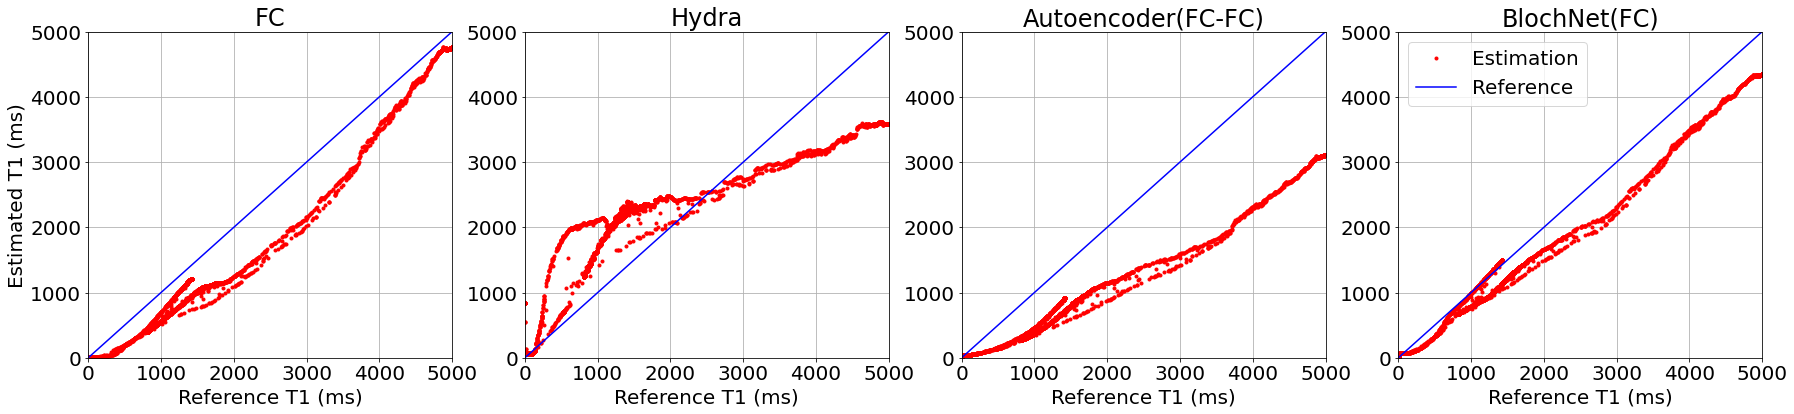

In [48]:
ncols=4
name_li = ['FC', 'Hydra', 'Autoencoder(FC-FC)', 'BlochNet(FC)']
fig, axes = plt.subplots(nrows=1, ncols=ncols,  figsize=(30,6))
for i in range(ncols):
    ax = axes[i]
    ax.plot(Label_T1_li[i], predictions_T1_li[i],'r.',label='Estimation')
    ax.plot(Label_T1_li[i], Label_T1_li[i],'b-',label='Reference')
    ax.grid(True)
    ax.set_xlim((0, 5000))
    ax.set_ylim((0, 5000))
    if i<1:  
        ax.set_ylabel('Estimated T1 (ms)')
    ax.set_xlabel('Reference T1 (ms)')
    plt.legend(loc='best')
    ax.set_title(name_li[i])
    
# plt.show()
plt.savefig('Line_T1_last.pdf',bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


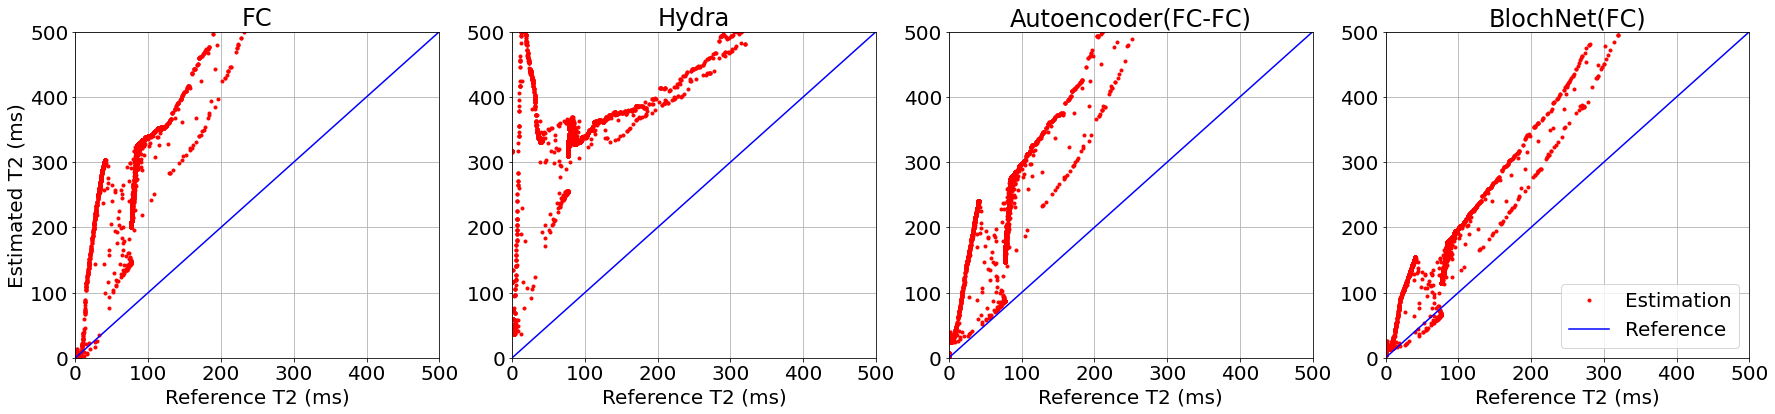

In [49]:
ncols=4
name_li = ['FC', 'Hydra', 'Autoencoder(FC-FC)', 'BlochNet(FC)']
fig, axes = plt.subplots(nrows=1, ncols=ncols,  figsize=(30,6))
for i in range(ncols):
    ax = axes[i]
    ax.plot(Label_T2_li[i], predictions_T2_li[i],'r.',label='Estimation')
    ax.plot(Label_T2_li[i], Label_T2_li[i],'b-',label='Reference')
    ax.grid(True)
    ax.set_xlim((0, 500))
    ax.set_ylim((0, 500))
    if i<1:  
        ax.set_ylabel('Estimated T2 (ms)')
    ax.set_xlabel('Reference T2 (ms)')
    plt.legend(loc='best')
    ax.set_title(name_li[i])
    
# plt.show()
plt.savefig('Line_T2_last.pdf',bbox_inches='tight')

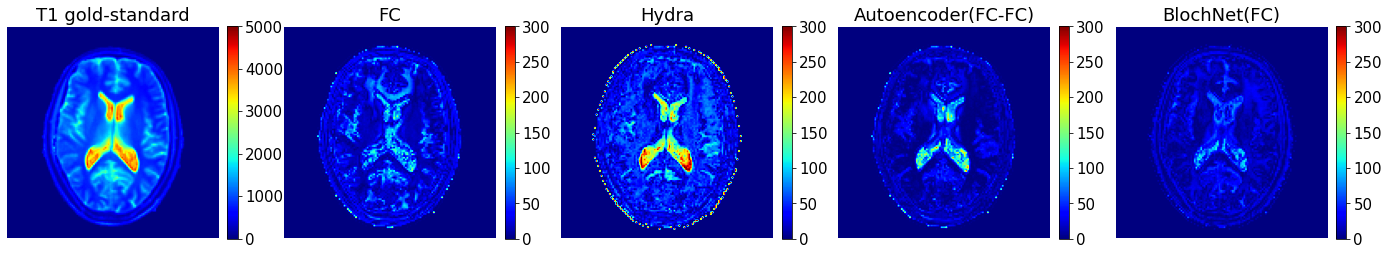

In [143]:
ncols=4
name_li = ['FC', 'Hydra', 'Autoencoder(FC-FC)', 'BlochNet(FC)']
fig, axes = plt.subplots(nrows=1, ncols=ncols,  figsize=(30,6))
for i in range(ncols):
    ax = axes[i]
    ax.plot(Label_T1_li[i], predictions_T1_li[i],'r.',label='Estimation')
    ax.plot(Label_T1_li[i], Label_T1_li[i],'b-',label='Reference')
    ax.grid(True)
    ax.set_xlim((0, 5000))
    ax.set_ylim((0, 5000))
    if i<1:  
        ax.set_ylabel('Estimated T1 (ms)')
    ax.set_xlabel('Reference T1 (ms)')
    plt.legend(loc='best')
    ax.set_title(name_li[i])
    
# plt.show()
plt.savefig('Brain_T1_error.pdf',bbox_inches='tight')

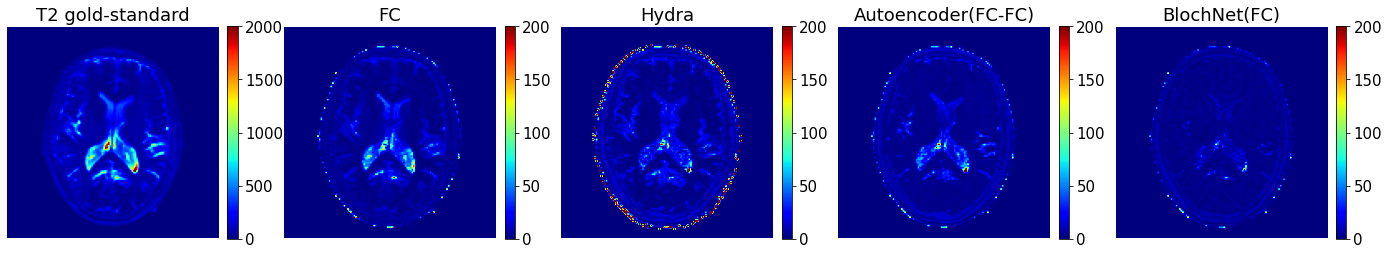

In [144]:
ncols=5
name_li = ['T2 gold-standard', 'FC', 'Hydra', 'Autoencoder(FC-FC)', 'BlochNet(FC)']
fig, axes = plt.subplots(nrows=1, ncols=ncols,  figsize=(24,20))
for i in range(ncols):
    ax = axes[i]
    vmax=200 if i>0 else 2000
    im = ax.imshow((error2_n_li[i]).real, cmap='jet', vmin=0, vmax=vmax)
    ax.axis("off")
    ax.set_title(name_li[i])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
# plt.show()
plt.savefig('Brain_T2_error.pdf',bbox_inches='tight')